# Using Shap for Feature Selection

Combining the tuning process with the optimal choice of features may be a need of every ranking-based selection algorithm. A ranking selection consists of iteratively dropping the less important features while retraining the model until convergence is reached. The model used for feature selection may differ (in parameter configuration or in the type) from the one used for final fitting and prediction. This may result in suboptimal performances. This is the case for example of RFE (Recursive Feature Elimination) or Boruta, where the features, selected through variable importance by an algorithm, are used by another algorithm for the final fit.

SHAP helps when we perform feature selection with ranking-based algorithms. Instead of using the default variable importance, generated by gradient boosting, we select the best features like the ones with the highest shapley values. The benefit of using SHAP is clear due to the bias present in native tree-based feature importance. The standard methods tend to overestimate the importance of continuous or high-cardinality categorical variables. This makes not trustable the importance of computation in case of feature shifts or changes in the number of categories.

## Using Shap-Hypetune

Shap-hypetune it allows combining hyperparameters tuning and features selection in a single pipeline with gradient boosting models. It supports grid-search, random-search, or bayesian-search and provides ranking feature selection algorithms like Recursive Feature Elimination (RFE), Recursive Feature Addition (RFA), or Boruta. The additional boost consists of offering the possibility to use SHAP importance for feature selection.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE

import warnings
warnings.simplefilter('ignore')

/home/bruno/miniconda3/envs/bru_ds/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/bruno/miniconda3/envs/bru_ds/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/bruno/miniconda3/envs/bru_ds/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
def binary_performances(y_true, y_prob, thresh=0.5, labels=['Positives','Negatives']):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, auc, roc_curve
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh).astype(int))
    
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
               'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    plt.subplot(132)
    plt.hist(y_prob[y_true==1], density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(y_prob[y_true==0], density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(thresh, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()

    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    print(prints)
    
    return results

In [3]:
### CREATE SYNTHETIC DATA ### 

X, y = make_classification(n_samples=150_000, 
                           n_features=50, n_informative=11, n_redundant=10,
                           n_classes=2, weights=[0.9, 0.1], class_sep=0.5, 
                           random_state=33, shuffle=True)

X = pd.DataFrame(X, columns=[f"feat_{c}" for c in range(X.shape[1])])
X.shape, y.shape

((150000, 50), (150000,))

In [4]:
### CREATE CATEGORICAL COLUMNS ###

cat_col = [f"feat_{c}" for c in range(10)]
X[cat_col] = X[cat_col].round(2).astype("category")

In [5]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=33)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=33)

In [6]:
### DEFINE TUNING VARIABLES ###

param_grid = {
    'n_estimators': 200,
    'learning_rate': [0.3, 0.2, 0.1],
    'num_leaves': [20, 25, 30, 35]
}

def AUC(y_true, y_hat):
    return 'auc', roc_auc_score(y_true, y_hat), True

results = {}

lgbm = LGBMClassifier(random_state=0, n_jobs=-1)

In [7]:
### HYPERPARAM TUNING WITH GRID-SEARCH ###

model = BoostSearch(lgbm, param_grid=param_grid, greater_is_better=True)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=3, verbose=0)


12 trials detected for ('n_estimators', 'learning_rate', 'num_leaves')

trial: 0001 ### iterations: 00010 ### eval_score: 0.87987
trial: 0002 ### iterations: 00008 ### eval_score: 0.88682
trial: 0003 ### iterations: 00010 ### eval_score: 0.884
trial: 0004 ### iterations: 00007 ### eval_score: 0.87937
trial: 0005 ### iterations: 00025 ### eval_score: 0.90459
trial: 0006 ### iterations: 00016 ### eval_score: 0.8999
trial: 0007 ### iterations: 00018 ### eval_score: 0.89381
trial: 0008 ### iterations: 00021 ### eval_score: 0.90012
trial: 0009 ### iterations: 00009 ### eval_score: 0.89066
trial: 0010 ### iterations: 00014 ### eval_score: 0.89568
trial: 0011 ### iterations: 00013 ### eval_score: 0.88415
trial: 0012 ### iterations: 00010 ### eval_score: 0.88876


BoostSearch(estimator=LGBMClassifier(random_state=0), greater_is_better=True,
            param_grid={'learning_rate': [0.3, 0.2, 0.1], 'n_estimators': 200,
                        'num_leaves': [20, 25, 30, 35]})

In this first section, we compute a fit on our train set searching only for the best parameter combination. The best model reaches a precision higher than 0.9 but with a low recall on our test data.

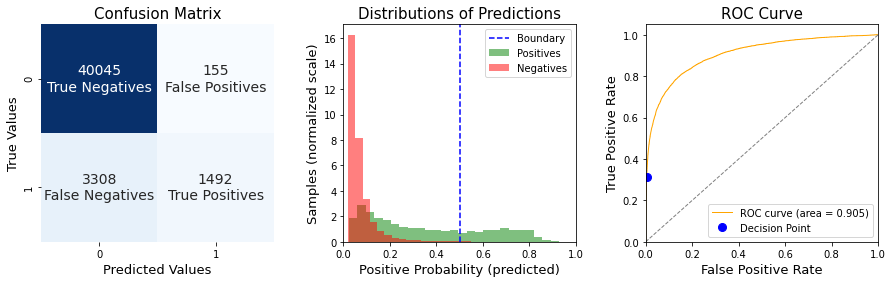

Precision: 0.906 | Recall: 0.311 | F1 Score: 0.463 | AUC: 0.905


In [8]:
### PLOT AND STORE RESULTS ###

results['Param Tuning'] = binary_performances(y_test, model.predict_proba(X_test))

In [9]:
### HYPERPARAM TUNING WITH GRID-SEARCH + RECURSIVE FEATURE ELIMINATION (RFE) ###

model = BoostRFE(lgbm, param_grid=param_grid, min_features_to_select=10, step=3, greater_is_better=True)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=3, verbose=0)


12 trials detected for ('n_estimators', 'learning_rate', 'num_leaves')

trial: 0001 ### iterations: 00010 ### eval_score: 0.87987
trial: 0002 ### iterations: 00008 ### eval_score: 0.88682
trial: 0003 ### iterations: 00014 ### eval_score: 0.88941
trial: 0004 ### iterations: 00012 ### eval_score: 0.88275
trial: 0005 ### iterations: 00025 ### eval_score: 0.90459
trial: 0006 ### iterations: 00022 ### eval_score: 0.90515
trial: 0007 ### iterations: 00027 ### eval_score: 0.90146
trial: 0008 ### iterations: 00025 ### eval_score: 0.90454
trial: 0009 ### iterations: 00020 ### eval_score: 0.89959
trial: 0010 ### iterations: 00014 ### eval_score: 0.89568
trial: 0011 ### iterations: 00020 ### eval_score: 0.89687
trial: 0012 ### iterations: 00015 ### eval_score: 0.89909


BoostRFE(estimator=LGBMClassifier(random_state=0), greater_is_better=True,
         min_features_to_select=10,
         param_grid={'learning_rate': [0.3, 0.2, 0.1], 'n_estimators': 200,
                     'num_leaves': [20, 25, 30, 35]},
         step=3)

Generally, feature selection is introduced to remove noisy predictors from the original set of data. We use Recursive Feature Elimination (RFE) while searching for the optimal set of parameters. In other words, for each parameter configuration, we iterate RFE on the initial training data. The procure can be speeded up by configuring proper fitting parameters, like early stopping, or setting larger steps while deleting the worse features. The pipeline with the best score on the validation set is stored and ready to use at inference time.

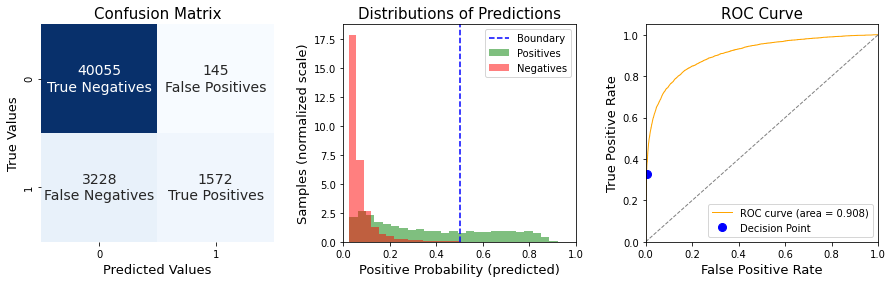

Precision: 0.916 | Recall: 0.328 | F1 Score: 0.482 | AUC: 0.908


In [10]:
### PLOT AND STORE RESULTS ###

results['Param Tuning + RFE'] = binary_performances(y_test, model.predict_proba(X_test))

In [11]:
### HYPERPARAM TUNING WITH GRID-SEARCH + RECURSIVE FEATURE ELIMINATION (RFE) WITH SHAP ###

model = BoostRFE(lgbm, param_grid=param_grid, min_features_to_select=10, step=3, greater_is_better=True,
                 importance_type='shap_importances', train_importance=False)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=3, verbose=0)


12 trials detected for ('n_estimators', 'learning_rate', 'num_leaves')

trial: 0001 ### iterations: 00046 ### eval_score: 0.91769
trial: 0002 ### iterations: 00026 ### eval_score: 0.91573
trial: 0003 ### iterations: 00061 ### eval_score: 0.93528
trial: 0004 ### iterations: 00035 ### eval_score: 0.91223
trial: 0005 ### iterations: 00062 ### eval_score: 0.91467
trial: 0006 ### iterations: 00030 ### eval_score: 0.90345
trial: 0007 ### iterations: 00085 ### eval_score: 0.91516
trial: 0008 ### iterations: 00024 ### eval_score: 0.90362
trial: 0009 ### iterations: 00064 ### eval_score: 0.91703
trial: 0010 ### iterations: 00090 ### eval_score: 0.94616
trial: 0011 ### iterations: 00051 ### eval_score: 0.90968
trial: 0012 ### iterations: 00010 ### eval_score: 0.89363


BoostRFE(estimator=LGBMClassifier(random_state=0), greater_is_better=True,
         importance_type='shap_importances', min_features_to_select=10,
         param_grid={'learning_rate': [0.3, 0.2, 0.1], 'n_estimators': 200,
                     'num_leaves': [20, 25, 30, 35]},
         step=3, train_importance=False)

In the end, we repropose the same procedure as before but using SHAP for RFE. SHAP is extremely efficient when used in conjunction with tree-based models. It uses a tree-path approach to follow the trees and extract the number of training examples that go down each leaf to provide the background computations. It is also less prone to be overconfident due to fact that we can calculate importance on the validation set and not on the training data (like classical tree-based importances).

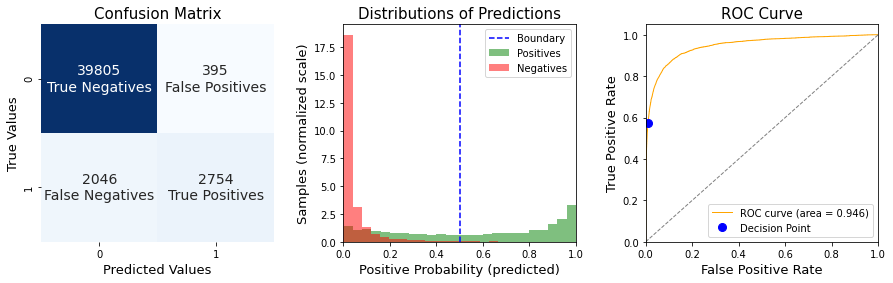

Precision: 0.875 | Recall: 0.574 | F1 Score: 0.693 | AUC: 0.946


In [12]:
### PLOT AND STORE RESULTS ###

results['Param Tuning + RFE w/ SHAP'] = binary_performances(y_test, model.predict_proba(X_test))

We register a great improvement in recall and F1 score. SHAP is able to discharge the low-quality categorical features preserving only the best predictors.

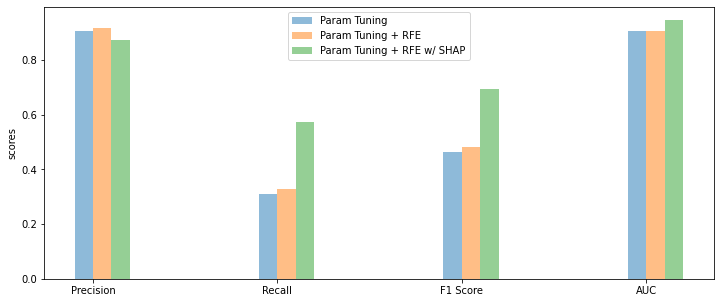

In [13]:
### PLOT AND COMPARE RESULTS ###

plt.figure(figsize=(12,5))

plt.bar(np.arange(4)-0.05, results['Param Tuning'].values(), 
        alpha=0.5, width=0.1, label='Param Tuning')
plt.bar(np.arange(4)+0.05, results['Param Tuning + RFE'].values(), 
        alpha=0.5, width=0.1, label='Param Tuning + RFE')
plt.bar(np.arange(4)+0.15, results['Param Tuning + RFE w/ SHAP'].values(), 
        alpha=0.5, width=0.1, label='Param Tuning + RFE w/ SHAP')

plt.xticks(range(4), results['Param Tuning'].keys())
plt.ylabel('scores'); plt.legend()
plt.show()

## Boruta and SHAP for better Feature Selection

A Comparison between different Feature Selection Techniques and how to choose them.

To summarize, there are different ways to carry out feature selection. The most famous in literature are filter-based and wrapper-based techniques. In filter-based procedures, unsupervised algorithms or statistics are used to query the most significant predictors. In wrapper-based methods, supervised learning algorithms are iteratively fitted to exclude the less significant features.

Generally, the wrapper-based methods are the most effective because they can extract correlations and dependencies between the features. On the other hand, they reveal to be more prone to overfit. To avoid this lack and leverage the best from the wrapper-based techniques, all we need to do is to adopt some simple yet powerful tips. We can achieve a better feature selection with a little data understanding and a secret ingredient. Don’t worry, we don’t use dark magic but the power of SHAP (SHapley Additive exPlanations).

### What is Boruta

Everyone knows (or can easily understand) how a Recursive Feature Elimination works. It recursively fits a supervised algorithm considering smaller sets of features. Where the excluded features are the ones that are considered less important according to the magnitude of some weights (e.g., the coefficients of linear models or the feature importances for tree-based models). 

Boruta, like RFE, is a wrapper-based technique for feature selection. It’s less known but just as powerful. The idea behind Boruta is really simple. Given a tabular dataset, we iteratively fit a supervised algorithm (generally a tree-based model) on an extended version of the data. The extended version, in each iteration, is composed of the original data with attached horizontally a copy of shuffled columns. We maintain only the features that in each iteration:
- have higher importance than the best of the shuffled features;
- are better than expected than random chance (using a binomial distribution).

Both RFE and Boruta use a supervised learning algorithm that provides a feature importance ranking. This model is the core of both techniques because it judges the goodness of each feature. Here may raise problems. The standard feature importance method of decision trees tends to overestimate the importance of high-frequency or high-cardinality variables. For Boruta and RFE this may result in a wrong feature selection.

### The Experiment

We choose a bank customer dataset where we try to predict if a customer is prone to churn soon. Before starting, we add to the dataset some random columns made by simple noise. We do this to understand how our model computes the feature importance. We start fitting and tuning our gradient boosting (LGBM). We repeat the process different times with various splitting seeds to override the randomness in data selection. The averaged feature importances are provided below.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from lightgbm import *
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE

import warnings
warnings.simplefilter('ignore')

In [15]:
url='https://raw.githubusercontent.com/cerlymarco/MEDIUM_NoteBook/master/ShapBoruta_FeatureSelection/Churn%20Modeling.csv'
### READ DATA ###

df = pd.read_csv(url, index_col='RowNumber')
df.drop(['Surname'], axis=1, inplace=True)

print(df.shape)
df.head()

(10000, 12)


CustomerId  CreditScore Geography  Gender  Age  Tenure    Balance  \
RowNumber                                                                      
1            15634602          619    France  Female   42       2       0.00   
2            15647311          608     Spain  Female   41       1   83807.86   
3            15619304          502    France  Female   42       8  159660.80   
4            15701354          699    France  Female   39       1       0.00   
5            15737888          850     Spain  Female   43       2  125510.82   

           NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
RowNumber                                                                     
1                      1          1               1        101348.88       1  
2                      1          0               1        112542.58       0  
3                      3          1               0        113931.57       1  
4                      2          0               0         93826.63       0  
5                      1          1               1         79084.10       0

In [16]:
### CONVERT CATEGORICAL COLUMNS ###

cat_cols = list(df.head().select_dtypes(object).columns)
df[cat_cols] = df[cat_cols].astype("category")

In [17]:
### ADD RANDOM ARTIFICIAL FEATURES ###

np.random.seed(123)

for c in range(1,6):
    df[f"RANDOM_{c}"] = np.random.normal(0,5, (df.shape[0],1))

In [18]:
### DEFINE TUNING VARIABLES ###

param_grid = {
    'n_estimators': 200,
    'learning_rate': [0.3, 0.2, 0.1],
    'num_leaves': [20, 25, 30]
}


def AUC(y_true, y_hat):
    return 'auc', roc_auc_score(y_true, y_hat), True

lgbm = LGBMClassifier(random_state=0, n_jobs=-1)

n_trials = 10

In [19]:
### TUNE PARAMETERS AND EXTRACT IMPORTANCES ###

importances = np.zeros((df.shape[1]-1,))

for i in range(n_trials):
    
    print("----- TRIAL {} -----".format(i+1))

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(['Exited'], axis=1), df['Exited'], test_size=0.5, shuffle=True, random_state=i)

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.2, shuffle=True, random_state=i)

    model = BoostSearch(lgbm, param_grid=param_grid, greater_is_better=True, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=4, verbose=0)
    
    importances += model.estimator_.feature_importances_
    
importances /= n_trials

----- TRIAL 1 -----
----- TRIAL 2 -----
----- TRIAL 3 -----
----- TRIAL 4 -----
----- TRIAL 5 -----
----- TRIAL 6 -----
----- TRIAL 7 -----
----- TRIAL 8 -----
----- TRIAL 9 -----
----- TRIAL 10 -----


Surprisingly the random features are very important for our model. Another wrong assumption consists in considering CustomerId as a useful predictor. This is a unique identifier of customers which is wrongly considered important by the gradient boosting.

Given these premises, let’s try some feature selection techniques on our data. We start with RFE. We combine the tuning of parameters with the feature selection process. As before, we repeat the whole procedure for different splitting seeds to mitigate randomness in data selection. For each trial, we store the selected features considering the standard tree-based feature importances and the SHAP importances. In this way, we can plot how many times a feature is selected at the end of the trials.

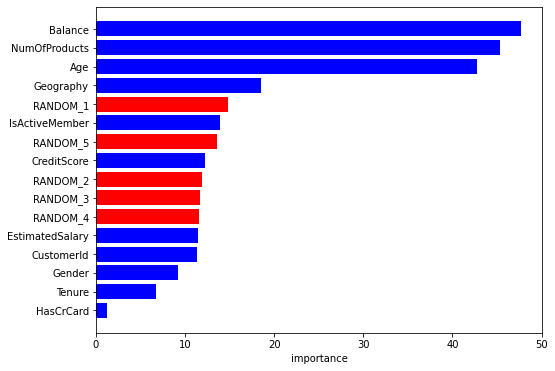

In [20]:
### PLOT IMPORTANCES ###

imp_id = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(range(len(importances)), importances[imp_id], 
         color=['red' if 'RANDOM' in c else 'blue' for c in X_train.columns[imp_id]])
plt.yticks(range(len(importances)), X_train.columns[imp_id])
plt.xlabel('importance')
plt.show()


In [21]:
### TUNE PARAMETERS PLUS RFE AND EXTRACT SUPPORTS ###

supports = np.zeros((df.shape[1]-1,))

for i in range(n_trials):
    
    print("----- TRIAL {} -----".format(i+1))

    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop(['Exited'], axis=1), df['Exited'], test_size=0.5, shuffle=True, random_state=i)

    model = BoostRFE(lgbm, min_features_to_select=1, step=1, param_grid=param_grid, greater_is_better=True, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=5, verbose=0)

    supports += model.support_.astype(int)

----- TRIAL 1 -----
----- TRIAL 2 -----
----- TRIAL 3 -----
----- TRIAL 4 -----
----- TRIAL 5 -----
----- TRIAL 6 -----
----- TRIAL 7 -----
----- TRIAL 8 -----
----- TRIAL 9 -----
----- TRIAL 10 -----


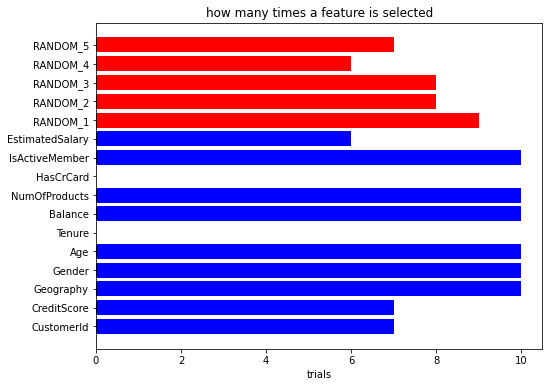

In [22]:
### PLOT VARIABLE SUPPORTS OVER TRIALS ###

plt.figure(figsize=(8,6))
plt.barh(range(len(supports)), supports, 
         color=['red' if 'RANDOM' in c else 'blue' for c in X_train])
plt.yticks(range(len(supports)), X_train.columns); plt.xlabel('trials')
plt.title('how many times a feature is selected')
plt.show()

RFE with the standard importances reveals to be inaccurate in our case. It often selects the random predictors as relevant together with the CustomerId. SHAP + RFE it’s quite better in not selecting the useless features but conceding at the same time some wrong selections.

As the last step, we repeat the same procedure but using Boruta.

In [23]:
### TUNE PARAMETERS PLUS BORUTA AND EXTRACT SUPPORTS ###

supports = np.zeros((df.shape[1]-1,))

for i in range(n_trials):
    
    print("----- TRIAL {} -----".format(i+1))

    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop(['Exited'], axis=1), df['Exited'], test_size=0.5, shuffle=True, random_state=i)

    model = BoostBoruta(lgbm, perc=100, alpha=0.05, max_iter=100, param_grid=param_grid, greater_is_better=True, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=5, verbose=0)

    supports += model.support_.astype(int)

----- TRIAL 1 -----
----- TRIAL 2 -----
----- TRIAL 3 -----
----- TRIAL 4 -----
----- TRIAL 5 -----
----- TRIAL 6 -----
----- TRIAL 7 -----
----- TRIAL 8 -----
----- TRIAL 9 -----
----- TRIAL 10 -----


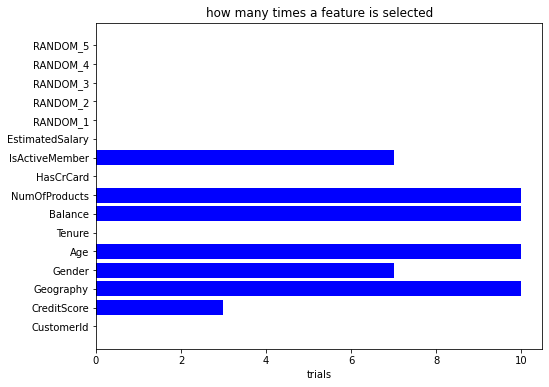

In [24]:
### PLOT VARIABLE SUPPORTS OVER TRIALS ###

plt.figure(figsize=(8,6))
plt.barh(range(len(supports)), supports, 
         color=['red' if 'RANDOM' in c else 'blue' for c in X_train])
plt.yticks(range(len(supports)), X_train.columns); plt.xlabel('trials')
plt.title('how many times a feature is selected')
plt.show()

In [25]:
### TUNE PARAMETERS PLUS RFE WITH SHAP AND EXTRACT SUPPORTS ###

supports = np.zeros((df.shape[1]-1,))

for i in range(n_trials):
    
    print("----- TRIAL {} -----".format(i+1))

    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop(['Exited'], axis=1), df['Exited'], test_size=0.5, shuffle=True, random_state=i)

    model = BoostRFE(lgbm, min_features_to_select=1, step=1, param_grid=param_grid, greater_is_better=True,
                     importance_type='shap_importances', train_importance=False, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=5, verbose=0)

    supports += model.support_.astype(int)

----- TRIAL 1 -----
----- TRIAL 2 -----
----- TRIAL 3 -----
----- TRIAL 4 -----
----- TRIAL 5 -----
----- TRIAL 6 -----
----- TRIAL 7 -----
----- TRIAL 8 -----
----- TRIAL 9 -----
----- TRIAL 10 -----


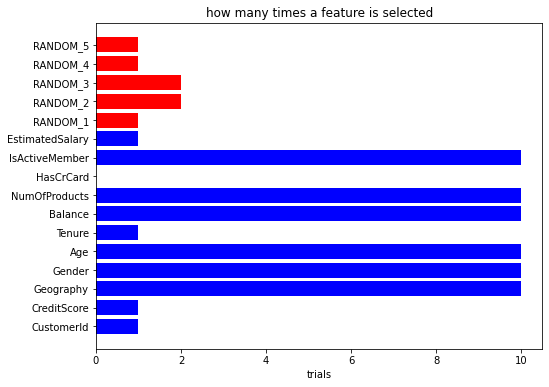

In [26]:
### PLOT VARIABLE SUPPORTS OVER TRIALS ###

plt.figure(figsize=(8,6))
plt.barh(range(len(supports)), supports, 
         color=['red' if 'RANDOM' in c else 'blue' for c in X_train])
plt.yticks(range(len(supports)), X_train.columns); plt.xlabel('trials')
plt.title('how many times a feature is selected')
plt.show()

In [27]:
### TUNE PARAMETERS PLUS BORUTA WITH SHAP AND EXTRACT SUPPORTS ###

supports = np.zeros((df.shape[1]-1,))

for i in range(n_trials):
    
    print("----- TRIAL {} -----".format(i+1))

    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop(['Exited'], axis=1), df['Exited'], test_size=0.5, shuffle=True, random_state=i)

    model = BoostBoruta(lgbm, perc=100, alpha=0.05, max_iter=100, param_grid=param_grid, greater_is_better=True,
                        importance_type='shap_importances', train_importance=False, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=5, verbose=0)

    supports += model.support_.astype(int)

----- TRIAL 1 -----
----- TRIAL 2 -----
----- TRIAL 3 -----
----- TRIAL 4 -----
----- TRIAL 5 -----
----- TRIAL 6 -----
----- TRIAL 7 -----
----- TRIAL 8 -----
----- TRIAL 9 -----
----- TRIAL 10 -----


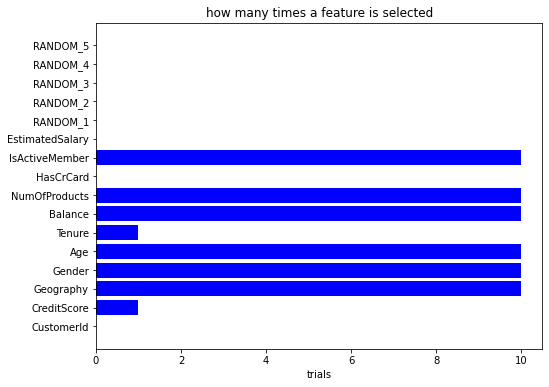

In [28]:
### PLOT VARIABLE SUPPORTS OVER TRIALS ###

plt.figure(figsize=(8,6))
plt.barh(range(len(supports)), supports, 
         color=['red' if 'RANDOM' in c else 'blue' for c in X_train])
plt.yticks(range(len(supports)), X_train.columns); plt.xlabel('trials')
plt.title('how many times a feature is selected')
plt.show()

## SHAP RFA vs RFE

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold

from hyperopt import hp
from hyperopt import Trials

from lightgbm import LGBMClassifier, early_stopping

from shaphypetune import BoostRFE, BoostRFA

import warnings
warnings.simplefilter('ignore')

In [30]:
def binary_performances(y_true, y_prob, thresh=0.5, labels=['Positives','Negatives']):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, auc, roc_curve
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh).astype(int))
    
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
               'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    plt.subplot(132)
    plt.hist(y_prob[y_true==1], density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(y_prob[y_true==0], density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(thresh, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()

    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    print(prints)

In [31]:
### CREATE SYNTHETIC DATA ### 

n_feat = 30
n_informative_feat = 11
n_redundant_feat = 6

assert n_feat > 0
assert n_informative_feat > 0
assert n_redundant_feat > 0
assert n_feat > (n_informative_feat + n_redundant_feat + 1)

X, y = make_classification(n_samples=20_000, n_features=n_feat, 
                           n_informative=n_informative_feat, n_redundant=n_redundant_feat,
                           n_classes=2, weights=[0.9, 0.1], class_sep=0.5, 
                           random_state=123, shuffle=False)

informartive_feat = range(0, n_informative_feat)
redundant_feat = range(informartive_feat[-1]+1, informartive_feat[-1] + n_redundant_feat)
noise_feat = range(redundant_feat[-1]+1, n_feat)

X = pd.DataFrame(
    X, columns= \
    [f"feat_{c}_info" for c in informartive_feat] + \
    [f"feat_{c}_combi" for c in redundant_feat] + \
    [f"feat_{c}_noise" for c in noise_feat] 
)

X.shape, y.shape

((20000, 30), (20000,))

In [32]:
### DEFINE TUNING VARIABLES ###

param_dist_hyperopt = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
    'num_leaves': 5 + hp.randint('num_leaves', 60),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0)
}

def F1(y_true, y_hat):
    return 'f1', f1_score(y_true, np.round(y_hat)), True

rfe_results = {}
rfa_results = {}
rfe_scores = {}
rfa_scores = {}

CV = StratifiedKFold(n_splits=8, shuffle=True, random_state=123)
lgbm = LGBMClassifier(n_estimators=200, random_state=123, n_jobs=-1)

In [33]:
### CV Recursive Feature Addition ###

y_pred = np.zeros((y.shape[0],2))

for i,(id_train,id_test) in enumerate(CV.split(X,y)):
    
    print(f"--- {i+1} fold ---")
    
    model = BoostRFA(
        lgbm, 
        step=3,
        param_grid=param_dist_hyperopt, 
        greater_is_better=True, 
        n_iter=30, sampling_seed=123
    )
    model.fit(
        X.iloc[id_train], y[id_train], 
        trials=Trials(), 
        eval_set=[(X.iloc[id_test], y[id_test])], 
        callbacks=[early_stopping(5, verbose=False)], eval_metric=F1
    )
    y_pred[id_test] = model.predict_proba(X.iloc[id_test])
    
    rfa_results[f"{i+1} fold"] = model.support_
    rfa_scores[f"{i+1} fold"] = model.best_score_
    print()

--- 1 fold ---

30 trials detected for ('class_weight', 'subsample', 'num_leaves', 'learning_rate', 'reg_alpha', 'reg_lambda', 'feature_fraction')

trial: 0001 ### iterations: 00019 ### eval_score: 0.56233
trial: 0002 ### iterations: 00019 ### eval_score: 0.56233
trial: 0003 ### iterations: 00019 ### eval_score: 0.56233
trial: 0004 ### iterations: 00019 ### eval_score: 0.56233
trial: 0005 ### iterations: 00019 ### eval_score: 0.56233
trial: 0006 ### iterations: 00019 ### eval_score: 0.56233
trial: 0007 ### iterations: 00019 ### eval_score: 0.56233
trial: 0008 ### iterations: 00019 ### eval_score: 0.56233
trial: 0009 ### iterations: 00019 ### eval_score: 0.56233
trial: 0010 ### iterations: 00019 ### eval_score: 0.56233
trial: 0011 ### iterations: 00067 ### eval_score: 0.77904
trial: 0012 ### iterations: 00067 ### eval_score: 0.77904
trial: 0013 ### iterations: 00067 ### eval_score: 0.77904
trial: 0014 ### iterations: 00067 ### eval_score: 0.77904
trial: 0015 ### iterations: 00067 ### ev

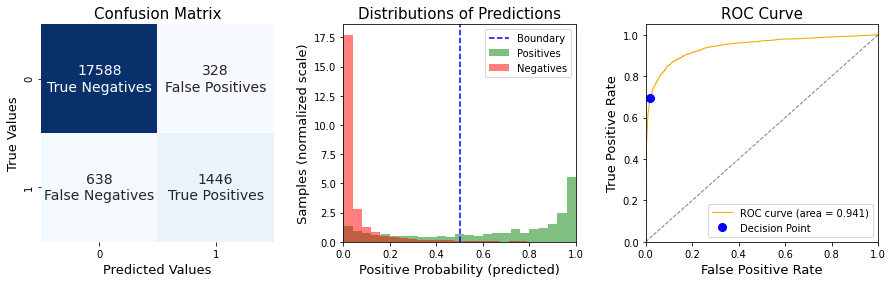

Precision: 0.815 | Recall: 0.694 | F1 Score: 0.75 | AUC: 0.941


In [34]:
### RFA CV performances ###

binary_performances(y, y_pred)

In [35]:
### CV Recursive Feature Elimination ###

y_pred = np.zeros((y.shape[0],2))

for i,(id_train,id_test) in enumerate(CV.split(X,y)):
    
    print(f"--- {i+1} fold ---")
    
    model = BoostRFE(
        lgbm, 
        step=3,
        param_grid=param_dist_hyperopt, 
        greater_is_better=True, 
        n_iter=30, sampling_seed=123
    )
    model.fit(
        X.iloc[id_train], y[id_train], 
        trials=Trials(), 
        eval_set=[(X.iloc[id_test], y[id_test])], 
        callbacks=[early_stopping(5, verbose=False)], eval_metric=F1
    )
    y_pred[id_test] = model.predict_proba(X.iloc[id_test])
    
    rfe_results[f"{i+1} fold"] = model.support_
    rfe_scores[f"{i+1} fold"] = model.best_score_
    print()

--- 1 fold ---

30 trials detected for ('class_weight', 'subsample', 'num_leaves', 'learning_rate', 'reg_alpha', 'reg_lambda', 'feature_fraction')

trial: 0001 ### iterations: 00021 ### eval_score: 0.56159
trial: 0002 ### iterations: 00021 ### eval_score: 0.56159
trial: 0003 ### iterations: 00078 ### eval_score: 0.73239
trial: 0004 ### iterations: 00078 ### eval_score: 0.73239
trial: 0005 ### iterations: 00078 ### eval_score: 0.73239
trial: 0006 ### iterations: 00078 ### eval_score: 0.73239
trial: 0007 ### iterations: 00078 ### eval_score: 0.73239
trial: 0008 ### iterations: 00078 ### eval_score: 0.73239
trial: 0009 ### iterations: 00078 ### eval_score: 0.73239
trial: 0010 ### iterations: 00078 ### eval_score: 0.73239
trial: 0011 ### iterations: 00041 ### eval_score: 0.77951
trial: 0012 ### iterations: 00041 ### eval_score: 0.77951
trial: 0013 ### iterations: 00041 ### eval_score: 0.77951
trial: 0014 ### iterations: 00041 ### eval_score: 0.77951
trial: 0015 ### iterations: 00041 ### ev

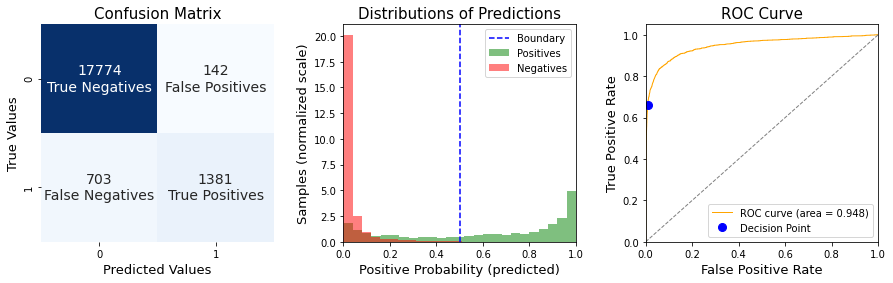

Precision: 0.907 | Recall: 0.663 | F1 Score: 0.766 | AUC: 0.948


In [36]:
### RFE CV performances ###

binary_performances(y, y_pred)

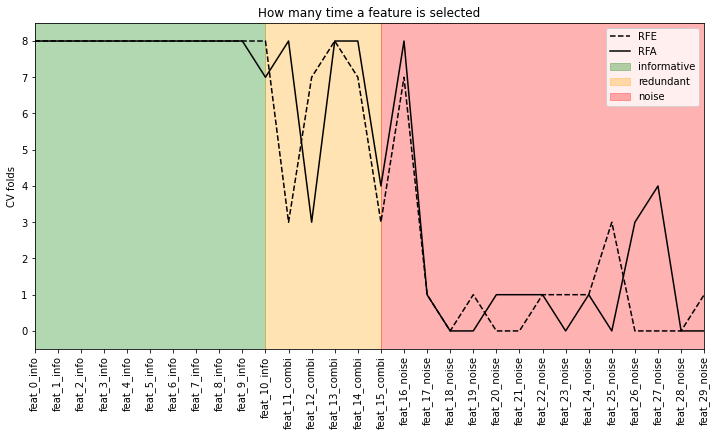

In [37]:
### SELECTED FEATURES ###

plt.figure(figsize=(12, 6))
plt.plot(
    range(n_feat), 
    np.sum(list(rfe_results.values()), axis=0), 
    label='RFE', c='black', linestyle='--'
)
plt.plot(
    range(n_feat), 
    np.sum(list(rfa_results.values()), axis=0), 
    label='RFA', c='black'
)
plt.xlim(0, n_feat-1)
plt.ylim(-0.5,len(rfe_results)+0.5)
plt.axvspan(informartive_feat[0], informartive_feat[-1], alpha=0.3, color='green', label='informative')
plt.axvspan(redundant_feat[0]-1, redundant_feat[-1], alpha=0.3, color='orange', label='redundant')
plt.axvspan(noise_feat[0]-1, noise_feat[-1], alpha=0.3, color='red', label='noise')
plt.xticks(range(n_feat), X.columns, rotation=90)
plt.title('How many time a feature is selected')
plt.ylabel('CV folds')
plt.legend(); plt.show()

## SHAP Boruta for Temporal Selection

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit

from lightgbm import LGBMRegressor, early_stopping
from shaphypetune import BoostRFE, BoostBoruta

import warnings
warnings.simplefilter('ignore')

In [39]:
### UTILITY FUNCTION TO GENERATE SYNTHETIC DATA ###

def gen_sinusoidal(timesteps, amp, freq, noise, timedependecy=True):
    
    X = np.arange(timesteps)
    if timedependecy:
        e = np.random.normal(0,np.linspace(0,noise, timesteps))
    else:
        e = np.random.normal(0,noise, timesteps)
    y = amp*np.sin(X*(2*np.pi/freq))+e
    
    return y

In [40]:
### CREATE SYNTHETIC DATA ###

np.random.seed(42)

timesteps = 8000
seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=9)
seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=9)
seas3 = gen_sinusoidal(timesteps=timesteps, amp=5, freq=12*7, noise=9)
random = np.random.normal(0,1, (timesteps,15)) # uniform(-10,10, (timesteps,15))

X = pd.DataFrame({
    'sin1': seas1,
    'sin2': seas2,
    'sin3': seas3
})

for i in range(random.shape[1]):
    X[f'random{i}'] = random[:,i]
    
seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=0, timedependecy=False)
seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=0, timedependecy=False)
seas3 = gen_sinusoidal(timesteps=timesteps, amp=5, freq=12*7, noise=0, timedependecy=False)
Y = pd.Series(seas1 + seas2 + seas3, index=X.index, name='target')

X.shape, Y.shape

((8000, 18), (8000,))

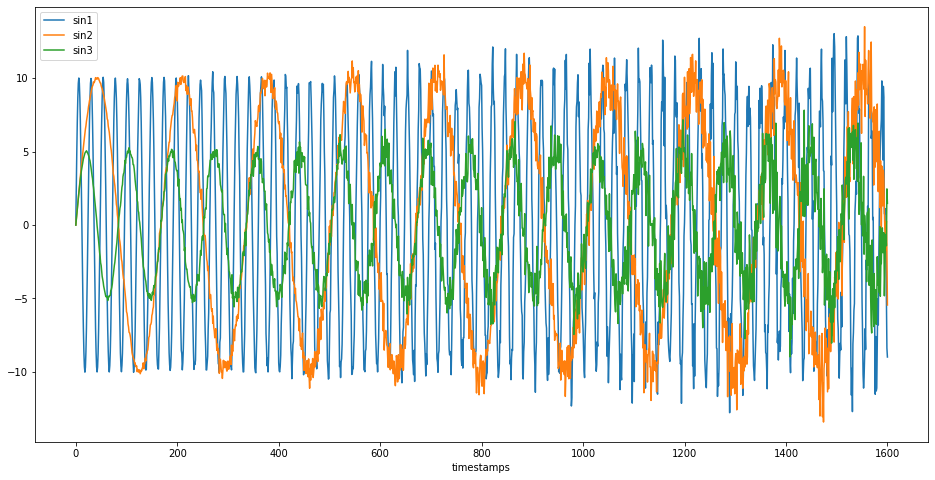

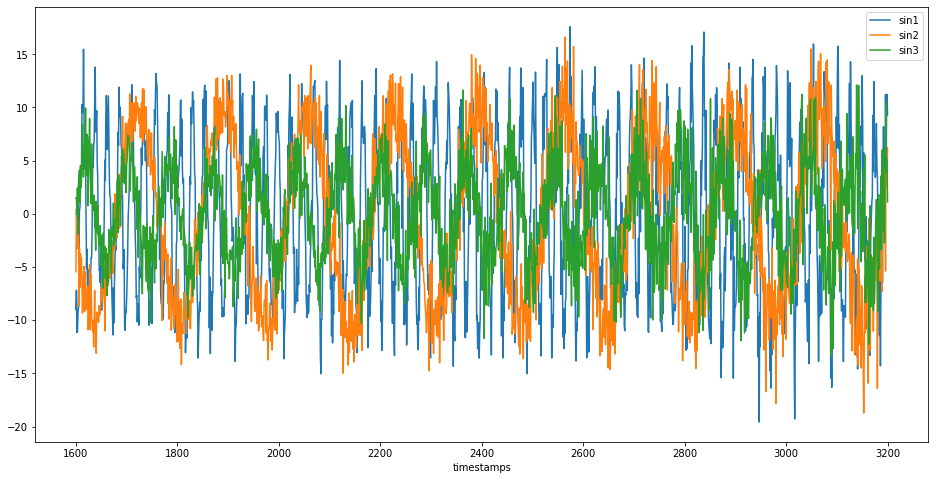

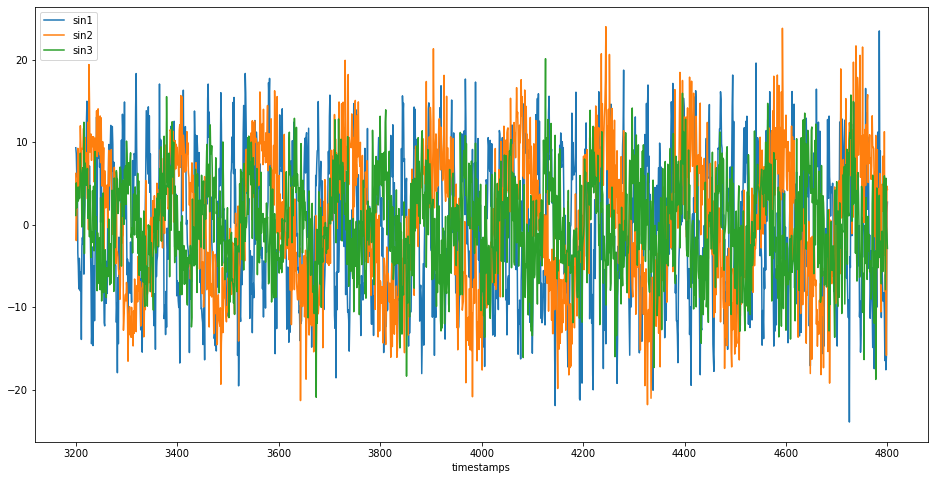

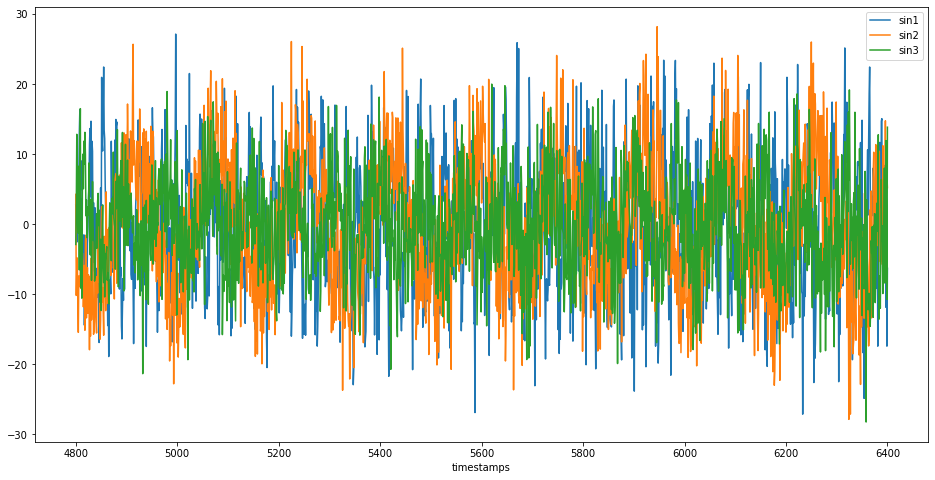

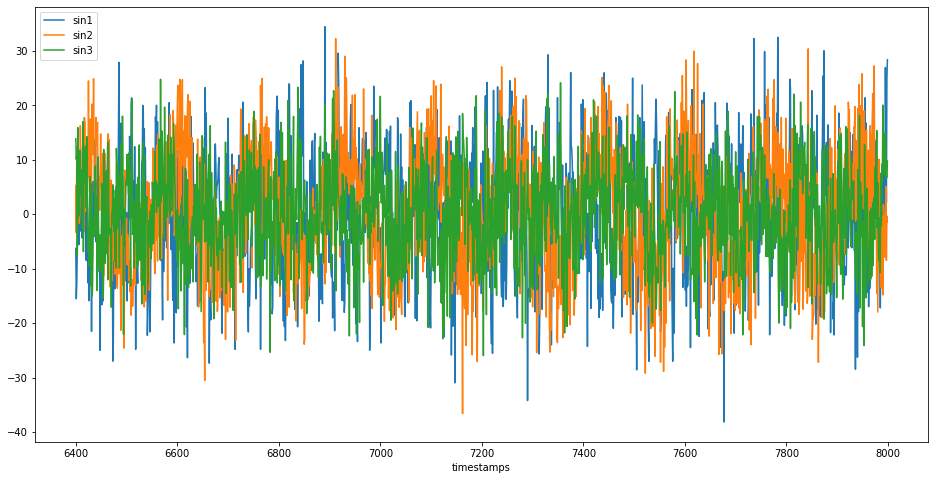

In [41]:
### PLOT SINUSOIDALS OVER TIME ###

chunck_size = len(X)//5

for start,end in zip(range(0, len(X), chunck_size), range(chunck_size, len(X)+chunck_size, chunck_size)):

    X.loc[start:end, X.columns.str.contains('sin')].plot(figsize=(16,8))
    plt.xlabel('timestamps')
    plt.show()

Text(0, 0.5, 'correlation')

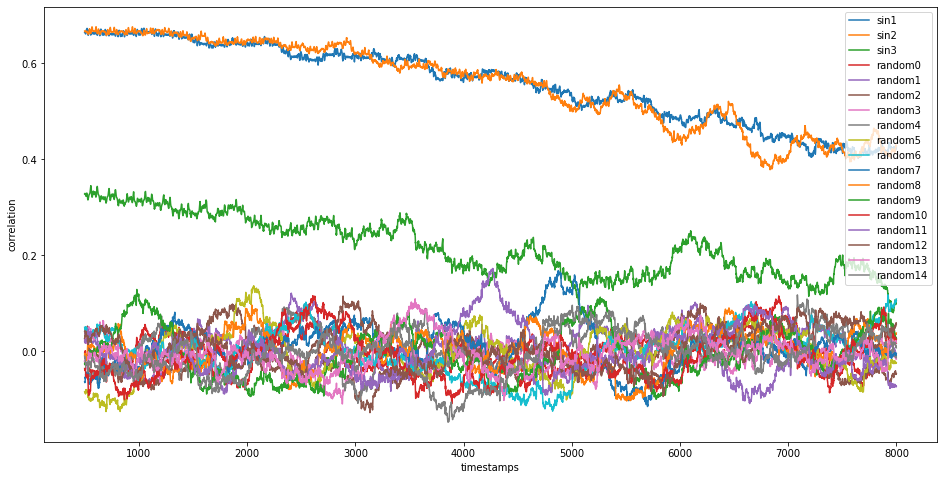

In [42]:
### PLOT ROLLING CORRELATIONS OVER TIME BETWEEN FEATURES AND TARGET ###

df_corr = pd.concat([X, pd.DataFrame(Y)], axis=1).rolling(500).corr()
df_corr = df_corr.loc[df_corr.index.get_level_values(1) == 'target'].drop(columns=['target'])
df_corr = df_corr.reset_index(drop=True)

df_corr.plot(figsize=(16,8), legend=True)
plt.xlabel('timestamps'); plt.ylabel('correlation')

In [43]:
### DEFINE EXPERIMENT UTILITIES ###

CV = TimeSeriesSplit(n_splits=15, test_size=24*7*3)
lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.5, random_state=42, n_jobs=-1)

In [44]:
### RUN BORUTA SHAP ###

select_trials = {}

for i,(id_train,id_test) in enumerate(CV.split(X)):
    
    print(f'--- FITTING SPLIT {i+1} ---')
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X.iloc[id_train], Y[id_train], 
        test_size=24*7, shuffle=False,
    )
    
    model = BoostBoruta(
        lgbm,
        importance_type='shap_importances', train_importance=False
    )
    model.fit(
        X_train, y_train, 
        eval_set=[(X_valid, y_valid)], 
        callbacks=[early_stopping(11, verbose=False)]
    )
    
    select_trials[i+1] = model.support_

--- FITTING SPLIT 1 ---
--- FITTING SPLIT 2 ---
--- FITTING SPLIT 3 ---
--- FITTING SPLIT 4 ---
--- FITTING SPLIT 5 ---
--- FITTING SPLIT 6 ---
--- FITTING SPLIT 7 ---
--- FITTING SPLIT 8 ---
--- FITTING SPLIT 9 ---
--- FITTING SPLIT 10 ---
--- FITTING SPLIT 11 ---
--- FITTING SPLIT 12 ---
--- FITTING SPLIT 13 ---
--- FITTING SPLIT 14 ---
--- FITTING SPLIT 15 ---


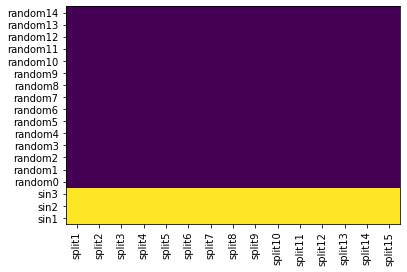

In [45]:
### PLOT BORUTA SHAP SELECTION RESULTS OVER TEMPORAL SPLITS ###

plt.pcolor(pd.DataFrame(select_trials, index=X.columns))
plt.yticks(np.arange(0.5, len(X.columns), 1), X.columns)
plt.xticks(np.arange(0.5, CV.n_splits, 1), [f"split{s}" for s in range(1,CV.n_splits+1)], rotation=90)
plt.title(""); plt.show()

In [46]:
### RUN RFE SHAP ###

select_trials = {}

for i,(id_train,id_test) in enumerate(CV.split(X)):
    
    print(f'--- FITTING SPLIT {i+1} ---')
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X.iloc[id_train], Y[id_train], 
        test_size=24*7, shuffle=False,
    )
    
    model = BoostRFE(
        lgbm, 
        importance_type='shap_importances', train_importance=False
    )
    model.fit(
        X_train, y_train, 
        eval_set=[(X_valid, y_valid)], 
        callbacks=[early_stopping(11, verbose=False)]
    )
    
    select_trials[i+1] = model.support_

--- FITTING SPLIT 1 ---
--- FITTING SPLIT 2 ---
--- FITTING SPLIT 3 ---
--- FITTING SPLIT 4 ---
--- FITTING SPLIT 5 ---
--- FITTING SPLIT 6 ---
--- FITTING SPLIT 7 ---
--- FITTING SPLIT 8 ---
--- FITTING SPLIT 9 ---
--- FITTING SPLIT 10 ---
--- FITTING SPLIT 11 ---
--- FITTING SPLIT 12 ---
--- FITTING SPLIT 13 ---
--- FITTING SPLIT 14 ---
--- FITTING SPLIT 15 ---


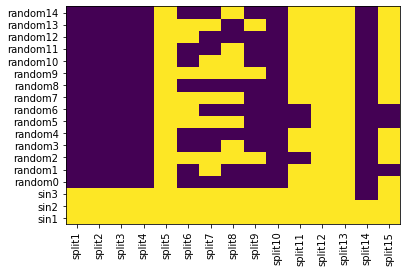

In [47]:
### PLOT RFE SHAP SELECTION RESULTS OVER TEMPORAL SPLITS ###

plt.pcolor(pd.DataFrame(select_trials, index=X.columns))
plt.yticks(np.arange(0.5, len(X.columns), 1), X.columns)
plt.xticks(np.arange(0.5, CV.n_splits, 1), [f"split{s}" for s in range(1,CV.n_splits+1)], rotation=90)
plt.title(""); plt.show()